
Entity evolution: 判断两个数据里面两个实体是否是同一个实体，也就是实体融合


In [7]:
#read file into DataStruct
import pandas as pd
import os
import codecs
os.chdir("D:\code\dataScience_jupyter_notebook\dataScienceHW"
         "\entity evolution")
print(os.getcwd() ,'\n' ,os.listdir())
with codecs.open("./data/stopwords.txt", "r", "utf-8") as file:
    stopwords = file.read()
 
amazonDf = pd.read_csv("./data/Amazon.csv", encoding= "utf-8")
googleDf = pd.read_csv("./data/Google.csv" , encoding= "utf-8")
#google coding error?? why!

D:\code\dataScience_jupyter_notebook\dataScienceHW\entity evolution 
 ['.ipynb_checkpoints', 'code - 副本.ipynb', 'code.ipynb', 'data', 'rewrite.ipynb', '数据分析训练题.docx']


In [8]:
#change perfect map into a list with tuples
perfectMapDf = pd.read_csv("data/Amazon_Google_perfectMapping.csv")
perfectMap = [] #store tuple
def buildPerfectMap(row):
    perfectMap.append((row['idAmazon'], row['idGoogleBase']))
perfectMapDf.apply(buildPerfectMap, axis= 1)
perfectMap[0:2]

[('b000jz4hqo',
  'http://www.google.com/base/feeds/snippets/18441480711193821750'),
 ('b00004tkvy',
  'http://www.google.com/base/feeds/snippets/18441110047404795849')]

In [9]:
#tokenize and record2tokens

In [10]:
import re
stopwords = stopwords.split('\n')
find_regex = r"\w+"

def simple_tokenize(string):
    string = string.lower()
    return re.findall(find_regex, string)
   
def tokenize(string):
    #data error
    if not type(string) is str: return[]
    tokens = simple_tokenize(string)
    for i in stopwords:
        while i in tokens:
            tokens.remove(i)
    return tokens

#build a dictionary(from id to list-- tokens)
def rec2tok(row, dic):
    #dic:dictionary that build mappings from record id to tokens
    if not type(row['description']) is str: row['description'] = ''
    if not type(row['manufacturer']) is str: row['manufacturer'] = ''
    dic[row['id']] = tokenize(row['title']+ row['description'] + 
                              row['manufacturer'])

In [16]:
#conpute tf idf 
#invertIndex

#increase: if key exist, self-increase, else =1
def inc(key, dic):
    if key in dic: dic[key] +=1
    else: dic[key] = 1

#return term frequence dic (percentage!)
def tf(tokens):
    tfs={}
    for i in tokens:
        inc(i, tfs)
    n = float(len(tokens)) #**
    for i in tfs:
        tfs[i] /=n
    return tfs

def idf(rec2tok):
    idfs={}
    N=float(len(amazonDf)+len(googleDf))
    for i in rec2tok:
        s=set(rec2tok[i])
        for j in s:inc(j,idfs)
    for i in idfs:idfs[i]=N/idfs[i]
    return idfs
def tfidf(tokens,idfs):
    ans=tf(tokens)
    s=set(tokens)
    for i in ans:
        ans[i]*=idfs[i]
    return ans 

def invertIndex(forward_index):
    #return a mapping from token to list-of-record-IDs
    ans={}
    for i in forward_index:
        for j in forward_index[i]:
            if j in ans:ans[j].append(i)
            else: ans[j]=[i]
    return ans

In [17]:
import math

# Optional utility  ; diancheng
#不太一样，是把相同token 的ifidf相乘！
def dotprod(a, b):
    ans=0
    for i in a:
        if i in b: ans+=a[i]*b[i]
    return ans

# Optional utility  pingfanghe qiugen
#norm 'mo'
def norm(a):
    ans=0
    for i in a:
        ans+=a[i]**2
    return math.sqrt(ans)

In [18]:
amazon_rec2tok = {}
google_rec2tok = {}

amazonDf.apply(lambda x:rec2tok(x,amazon_rec2tok),axis=1)
googleDf.apply(lambda x:rec2tok(x,google_rec2tok),axis=1)

amazon_inv=invertIndex(amazon_rec2tok)

In [23]:
from collections import Counter #to add two?? 
idfs_all = dict(Counter(idf(amazon_rec2tok)) + 
                Counter(idf(google_rec2tok)))

#weights:dict  id:tf_idf
amazon_weights = {i:tfidf(amazon_rec2tok[i], idfs_all) for i in amazon_rec2tok}
google_weights = {i:tfidf(google_rec2tok[i], idfs_all) for i in google_rec2tok}
#norm for every id 
amazon_norm={i:norm(amazon_weights[i]) for i in amazon_weights}
google_norm={i:norm(google_weights[i]) for i in google_weights}

http://www.google.com/base/feeds/snippets/11125907881740407428   {'learning': 17.675898752751284, 'quickbooks': 141.96906318082787, '2007learning': 917.8000000000001, '2007intuit': 917.8000000000001}
http://www.google.com/base/feeds/snippets/11538923464407758599   {'superstart': 305.93333333333334, 'fun': 9.144500345269805, 'reading': 25.378560606060606, 'writing': 40.5920681063123, 'designed': 3.4958492642799217, 'help': 3.4441869247108805, 'kids': 11.33592261904762, 'learn': 5.139497262319562, 'read': 30.419507575757578, 'write': 18.34356368563686, 'better': 7.007878236245955, 'exercises': 19.751190476190477, 'puzzle': 19.989962121212123, 'solving': 42.06583333333333, 'creative': 4.713453754300749, 'decoding': 458.90000000000003}
http://www.google.com/base/feeds/snippets/11343515411965421256   {'qb': 31.21768707482993, 'pos': 208.11791383219955, '6': 6.957762252220431, '0': 3.807611832611833, 'basic': 25.99291977561135, 'softwareqb': 218.52380952380952, 'retail': 23.260237428304652, 

In [42]:
def build_sim(id, weight, norm, weight2, norm2, inv, sims):
    for token in weight:
        #invert index 化简运算
        if token in inv:
            for id2 in inv[token]:
                if  (id2,id)  not in sims:
                #if  (id,id2)  not in sims: 是要和 perfect map 相比较的啊！！！
                    sims[(id2,id)] = dotprod(weight, weight2[id2]) / norm/ norm2[id2]

sims ={}
for id in google_weights:
    build_sim(id, google_weights[id], google_norm[id], 
              amazon_weights, amazon_norm, amazon_inv, sims)

2330078
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b0006se5bq')    0.00012185127636044963
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b00029bqa2')    5.1787850071403525e-05
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b00002sac9')    4.478022616485206e-05
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b000o24l3q')    1.492994283106957e-05
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b000ivhozk')    8.84092709347781e-05
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b0009stm6g')    0.0009388437064673534
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b0000aka82')    0.0001232878565658295
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b000jj4fbw')    6.545065106110934e-05
('http://www.google.com/base/feeds/snippets/11125907881740407428', 'b000ozhfsq')    0.0001449237927297006
('http://www.google.com/base/feeds/sn

evalutaion & 调参 threshold

In [43]:
true_dup_sims = []
def truepos(threshold):
    global true_dup_sims
    true_dup_sims=[]
    for i in sims:
        if sims[i]>threshold: 
            true_dup_sims.append(i)
def bin(similarity):
    return int(similarity * nthresholds)

# TODO Implement this
def falsepos(threshold):
    ans=0
    for i in true_dup_sims:
        if not i in perfectMap: ans+=1
    return ans


# TODO Implement this (returns a float)
def precision(threshold):
    truepos(threshold)
    a=len(true_dup_sims)-falsepos(threshold)
    b=len(true_dup_sims)
    return a*1.0/b

In [47]:
#调参
thresholds = [float(n) / 100 for n in range(2, 100)]
p=[precision(n) for n in thresholds]
for i in p: print(p)

[0.03877210079354031, 0.05308672831792052, 0.06672330414324924, 0.08067557596130195, 0.09392482088526842, 0.10696546147626199, 0.11877394636015326, 0.1318236352729454, 0.14547903687489477, 0.15714285714285714, 0.17200921852084644, 0.1835982492513246, 0.19491951710261568, 0.20592230372181472, 0.21891573364761344, 0.2288698955365622, 0.24090597117364448, 0.25349008082292435, 0.264291307752545, 0.27796467619848614, 0.2859042553191489, 0.2976525821596244, 0.3076540755467197, 0.31664058424621805, 0.3263850795392211, 0.3368237347294939, 0.3495085995085995, 0.3596889176928062, 0.3724279835390947, 0.38412017167381973, 0.38774002954209746, 0.39600920951650037, 0.4091639871382637, 0.417296389588581, 0.42628774422735344, 0.4376163873370577, 0.44695481335952847, 0.4550102249488753, 0.4622741764080765, 0.4689880304678999, 0.4794050343249428, 0.4904076738609113, 0.5018820577164367, 0.5136540962288687, 0.5203252032520326, 0.5232722143864598, 0.5297532656023222, 0.5319148936170213, 0.5412698412698412,

Populating the interactive namespace from numpy and matplotlib
最大准确率阈值 0.74
最大准确率： 0.6407766990291263


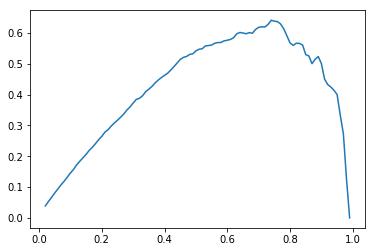

In [48]:
get_ipython().magic('pylab inline')
plt.plot(thresholds,p)
for i in range(0,98):
    if p[i]==max(p): 
        print ("最大准确率阈值",thresholds[i])
    
print ("最大准确率：",max(p))